In [15]:
import pandas as pd
import numpy as np
import os
import pickle

In [16]:
os.getcwd()

'/Users/JamesHeinlein/TDICapstone'

In [29]:
setSize = "large"

movies = pd.read_csv("./Datasets/"+setSize+"/movies.csv")
links = pd.read_csv("./Datasets/"+setSize+"/links.csv",usecols=['movieId','tmdbId'])
ratings = pd.read_csv("./Datasets/"+setSize+"/ratings.csv",usecols=['userId','movieId','rating'])

In [30]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [31]:
moviesWLinks = pd.merge(movies, links)
userReviews = pd.merge(ratings, moviesWLinks, how="left")
del movies, links

In [32]:
userReviews.head()

,userId,movieId,rating,title,genres,tmdbId
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,862.0
1,1,110,4.0,Braveheart (1995),Action|Drama|War,197.0
2,1,158,4.0,Casper (1995),Adventure|Children,8839.0
3,1,260,4.5,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,11.0
4,1,356,5.0,Forrest Gump (1994),Comedy|Drama|Romance|War,13.0


In [33]:
# Smaller view of DF which just has movie titles and tmdbId
titles = userReviews.groupby('title').max().reset_index()[['title','tmdbId']]
#titles = titles.sort_values('tmdbId')

In [34]:
# Aggregate the ratings by movie
# Compute the variance of ratings and number of reviews of each movie
mostViewed = userReviews.groupby('tmdbId').agg({'rating':['var'],'userId':['count']})
mostViewed = mostViewed.reset_index()
mostViewed = mostViewed.rename(columns={'userId':'nWatched','rating':'rating Variance'})
mostViewed.columns = mostViewed.columns.get_level_values(0)


In [35]:
# Get Most "controversial" movies out of top 100 Viewed Movies
# Use Variance of ratings as the proxy for this
mostViewed = mostViewed.merge(titles,how='inner')
mostViewed[mostViewed['nWatched'] > 30000].sort_values('nWatched',ascending=False).sort_values('rating Variance',ascending=False).head(50)

,tmdbId,rating Variance,nWatched,title
3083,8467.0,1.457024,40371,Dumb & Dumber (Dumb and Dumber) (1994)
1208,1893.0,1.312820,41061,Star Wars: Episode I - The Phantom Menace (1999)
1375,2105.0,1.301872,31431,American Pie (1999)
459,597.0,1.294748,50706,Titanic (1997)
1739,3049.0,1.246743,47829,Ace Ventura: Pet Detective (1994)
3658,9598.0,1.230024,37698,Babe (1995)
642,817.0,1.218708,31144,Austin Powers: The Spy Who Shagged Me (1999)
9420,19995.0,1.166469,36901,Avatar (2009)
466,604.0,1.114750,30788,"Matrix Reloaded, The (2003)"
464,602.0,1.095010,63687,Independence Day (a.k.a. ID4) (1996)


<Axes: ylabel='Frequency'>

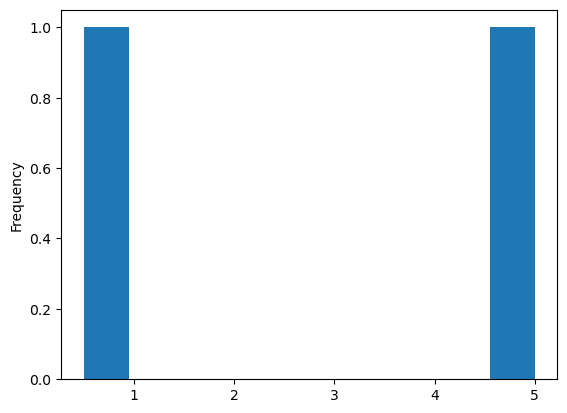

In [36]:
userReviews[userReviews['tmdbId'] == 77640.0]['rating'].plot.hist(bins=10)

In [37]:
userReviews['userId'].nunique()

330975

In [38]:
userReviews.groupby('tmdbId').agg({'rating':['mean']})

,rating
,mean
tmdbId,
2.0,3.692661
3.0,3.671329
5.0,3.420156
6.0,2.931991
11.0,4.092400
...,...
1144338.0,5.000000
1145358.0,1.666667


In [39]:
userReviews.groupby('tmdbId').agg({'rating':['mean']})

,rating
,mean
tmdbId,
2.0,3.692661
3.0,3.671329
5.0,3.420156
6.0,2.931991
11.0,4.092400
...,...
1144338.0,5.000000
1145358.0,1.666667


In [40]:
userReviews.groupby('userId').agg({'rating':['mean']})

,rating
,mean
userId,
1,4.008065
2,3.527473
3,4.900000
4,4.366667
5,3.418605
...,...
330971,4.068627
330972,3.343750


In [83]:
globalMean = userReviews.groupby('userId').agg({'rating':['mean']}).agg('mean').iloc[0]
globalMean

3.696335326913785

<Axes: ylabel='Frequency'>

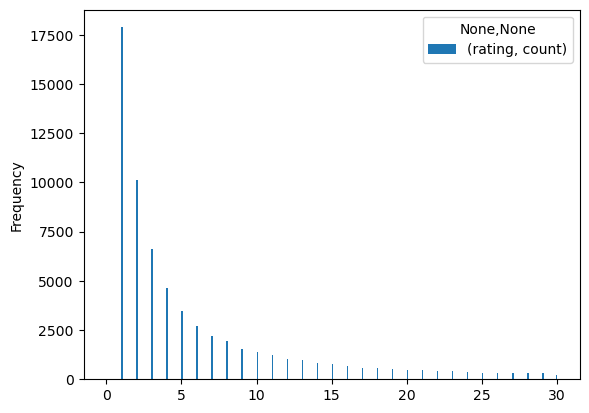

In [45]:
userReviews.groupby('tmdbId').agg({'rating':['count']}).plot.hist(bins=300,range=(0,30))

In [67]:
reviewCt = userReviews.groupby('tmdbId').agg({'rating':'count'})
reviewCt = reviewCt.rename({'rating':'viewCt'})
reviewCt.columns = ['viewCt']
reviewCt.columns
revCt = userReviews.join(reviewCt, on='tmdbId')

In [68]:
revCt.head()

,userId,movieId,rating,title,genres,tmdbId,viewCt
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,862.0,76813.0
1,1,110,4.0,Braveheart (1995),Action|Drama|War,197.0,75514.0
2,1,158,4.0,Casper (1995),Adventure|Children,8839.0,16591.0
3,1,260,4.5,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,11.0,97202.0
4,1,356,5.0,Forrest Gump (1994),Comedy|Drama|Romance|War,13.0,113581.0


In [69]:
revCt.shape

(33832162, 7)

In [77]:
# Experimenting with making a cutoff for min reviews required to be suggested in large DS
revCt[revCt['viewCt'] > 10000].shape

(18684073, 7)